In [1]:
import sys
sys.path.append('../')
import numpy as np
import importlib
import utils as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Activation, Dropout
from tensorflow.keras.regularizers import L1L2
importlib.reload(u)

Using TensorFlow backend.


<module 'utils' from '..\\utils.py'>

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [3]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=10)
cases = datadict['cases_calibrated']
deaths = datadict['deaths_calibrated']

In [8]:
demographics = u.load_demographics_data()
demographics.head()

,FIPS,total_pop,60plus,area,median_age,pop_white,pop_black,pop_hispanic
0,01001,55036,10523,594.44,37.8,76.9,19.1,2.8
1,01003,203360,53519,1589.78,42.8,86.3,9.5,4.5
2,01005,26201,6150,884.88,39.9,47.4,47.6,4.3
3,01007,22580,4773,622.58,39.9,76.7,22.3,2.4
4,01009,57667,13600,644.78,40.8,95.5,1.5,9.1


In [70]:
pop = np.expand_dims(demographics['total_pop'].values, axis=1)
cases_norm = cases / pop * 10000
deaths_norm = deaths / pop * 10000

In [71]:
def transform(x):
    x0 = np.expand_dims(x[:, 0], axis=1)
    t = np.diff(x)
    t0 = np.expand_dims(t[:, 0], axis=1)
    t = np.diff(t)
    return t, t0, x0

In [72]:
def untransform(t, t0, x0, a=1):
    x = np.hstack([t0, t])
    x = np.cumsum(x, axis=a)
    x = np.hstack([x0, x])
    x = np.cumsum(x, axis=a)
    return x

In [73]:
cases2, ct0, cx0 = transform(cases_norm)
deaths2, dt0, dx0 = transform(deaths_norm)

(3142, 93)


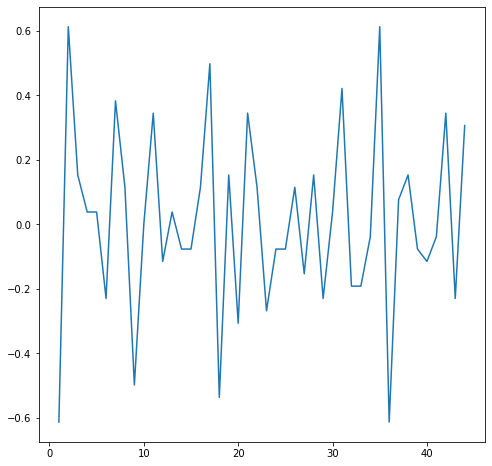

In [63]:
d = cases2
x1 = np.linspace(1, d.shape[1], d.shape[1])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(x1, d[206])
print(d.shape)
plt.show()

In [74]:
X_train = []
y_train = []
X_test = []
y_test = []
lag = 8
validation_steps = 9
for j in range(deaths2.shape[0]):
    d = deaths2[j]
    c = cases2[j]
    if np.all(np.isnan(d)) or np.all(np.isnan(c)):
        continue
    s = np.argmax(np.isnan(d))
    for i in range(s):
        if np.any(np.isnan(d[i:i+lag+1])) or np.any(np.isnan(c[i:i+lag+1])):
            break
        x = np.vstack([c[i:i+lag], d[i:i+lag], np.full((lag,), i)]).T
        if i < s - validation_steps:
            X_train.append(x)
            y_train.append([c[i+lag], d[i+lag]])
        else:
            X_test.append(x)
            y_test.append([c[i+lag], d[i+lag]])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [75]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(22505, 8, 3) (22505, 2) (1497, 8, 3) (1497, 2)


In [76]:
def LSTM_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=X_train.shape[1:], recurrent_regularizer=L1L2(0,1e-2), kernel_regularizer=L1L2(0, 0.1)))
    model.add(Dropout(0.1))
    model.add(Dense(2, kernel_regularizer=L1L2(0.1, 0.1)))
    return model

In [77]:
with tf.device('/GPU:0'):
    model = LSTM_model()
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 17,538
Trainable params: 17,538
Non-trainable params: 0
_________________________________________________________________


In [78]:
with tf.device('/GPU:0'):
    model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=True)

Epoch 1/50
313/313 - 1s - loss: 3.5135 - val_loss: 5.5162
Epoch 2/50
313/313 - 1s - loss: 2.4472 - val_loss: 5.4335
Epoch 3/50
313/313 - 1s - loss: 2.4306 - val_loss: 5.4306
Epoch 4/50
313/313 - 1s - loss: 2.4301 - val_loss: 5.4301
Epoch 5/50
313/313 - 1s - loss: 2.4292 - val_loss: 5.4299
Epoch 6/50
313/313 - 1s - loss: 2.4288 - val_loss: 5.4301
Epoch 7/50
313/313 - 1s - loss: 2.4300 - val_loss: 5.4297
Epoch 8/50
313/313 - 1s - loss: 2.4376 - val_loss: 5.4298
Epoch 9/50
313/313 - 1s - loss: 2.4299 - val_loss: 5.4301
Epoch 10/50
313/313 - 1s - loss: 2.4302 - val_loss: 5.4303
Epoch 11/50
313/313 - 1s - loss: 2.4294 - val_loss: 5.4300
Epoch 12/50
313/313 - 1s - loss: 2.4295 - val_loss: 5.4300
Epoch 13/50
313/313 - 1s - loss: 2.4310 - val_loss: 5.4298
Epoch 14/50
313/313 - 1s - loss: 2.4293 - val_loss: 5.4300
Epoch 15/50
313/313 - 1s - loss: 2.4293 - val_loss: 5.4299
Epoch 16/50
313/313 - 1s - loss: 2.4290 - val_loss: 5.4302
Epoch 17/50
313/313 - 1s - loss: 2.4295 - val_loss: 5.4302
Epoch 

In [203]:
model.save('lstm_2.h5')

In [79]:
cases_predictions = {}
deaths_predictions = {}
count = 0
for county in range(deaths2.shape[0]):
    count += 1
    if count % 50 == 0:
        print(count)
    d = deaths2[county]
    c = cases2[county]
    if np.all(np.isnan(d)) or np.all(np.isnan(c)):
        continue
    s = np.argmax(np.isnan(d))
    if s < lag + validation_steps:
        continue
    i = s - lag - validation_steps
    predictions = np.vstack([c[i:i+lag], d[i:i+lag]]).T
    curr = 0
    for day in range(14):
        X = np.expand_dims(np.hstack([predictions[curr:curr+lag], np.full((lag, 1), i)]), axis=0)
        y = model.predict(X)
        predictions = np.vstack([predictions, y])
        curr += 1
        i += 1
    cases_predictions[county] = predictions[lag:].T[0]
    deaths_predictions[county] = predictions[lag:].T[1]

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100


In [80]:
print(cases_predictions.keys())

dict_keys([0, 1, 7, 8, 10, 14, 21, 24, 25, 27, 34, 35, 36, 38, 40, 41, 44, 45, 46, 47, 48, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 69, 74, 77, 78, 79, 96, 98, 103, 104, 105, 106, 107, 109, 110, 114, 120, 122, 126, 128, 133, 136, 145, 146, 150, 153, 156, 168, 170, 172, 173, 180, 181, 182, 183, 186, 189, 192, 194, 195, 197, 198, 199, 200, 204, 205, 206, 209, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 233, 234, 235, 236, 239, 241, 242, 243, 244, 246, 250, 251, 252, 260, 262, 263, 265, 267, 270, 274, 278, 279, 282, 283, 287, 288, 293, 295, 298, 303, 304, 306, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 327, 328, 329, 330, 331, 332, 334, 335, 336, 345, 346, 347, 349, 353, 354, 355, 358, 359, 360, 361, 362, 363, 364, 365, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 383, 385, 389, 391, 393, 394, 397, 401, 403, 404, 405, 406, 408, 411, 414, 415, 416, 417, 

In [81]:
cp2 = {}
dp2 = {}
pop = np.expand_dims(demographics['total_pop'].values, axis=1)
for county in cases_predictions:
    d = deaths2[county]
    c = cases2[county]
    s = np.argmax(np.isnan(d))
    d2 = np.concatenate([d[:(s - validation_steps)], deaths_predictions[county]])
    c2 = np.concatenate([c[:(s - validation_steps)], cases_predictions[county]])
    
    cp2[county] = untransform(c2, ct0[county], cx0[county], 0)
    dp2[county] = untransform(d2, dt0[county], dx0[county], 0)
    
    cp2[county] = cp2[county] * pop[county, 0] / 10000
    dp2[county] = dp2[county] * pop[county, 0] / 10000

In [82]:
mse = 0
n = 0
for county in deaths_predictions:
    n += 1
    s = np.argmax(np.isnan(deaths2[county]))
    pred = dp2[county][(s - validation_steps):s]
    real = deaths[county][(s - validation_steps):s]
    mse += np.sum((pred - real)**2)
    break
print(mse / (n*validation_steps))

0.35807288812804045


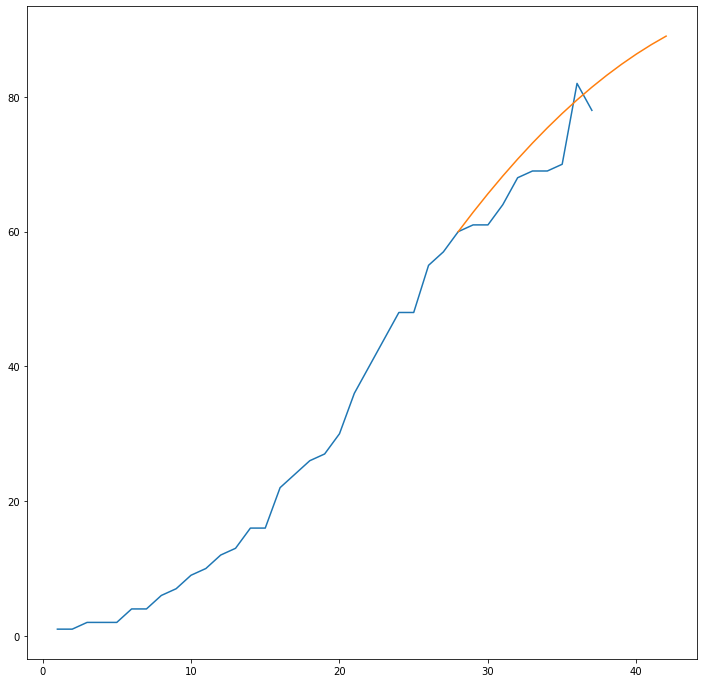

In [87]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

county = 306

d1 = deaths
x1 = np.linspace(1, d1.shape[1], d1.shape[1])
plt.plot(x1, d1[county])

s = np.argmax(np.isnan(d1[county])) - 1
d2 = dp2[county]
x2 = np.linspace(1, d2.shape[0], d2.shape[0])
plt.plot(x2[s - validation_steps:], d2[s - validation_steps:])

plt.show()